# Environment Specification
1. Operating System: Windows 11
2. Python Version: 3.8.20
3. TensorFlow Version: 2.6.0-GPU
4. GPU: NVIDIA GeForce RTX 4070 Laptop GPU
5. CUDA Version: 11.2
6. Installed Packages:
   - NumPy: 1.21.5
   - Pandas: 1.3.5
   - Scikit-learn: 1.0.2
   - Matplotlib: 3.4.3
   - Seaborn: 0.11.2
7. Hardware:
   - CPU: 13th Gen Intel(R) Core(TM) i9-13900H
   - RAM: 16 GB

# Import Necessary Libraries

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten ,Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from collections import Counter
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np
import os 
import random
import cv2
import json
from sklearn.model_selection import train_test_split

# Creating training and testing dataset

In [16]:
data = []
animals = ["dog", "horse", "elefant", "butterfly", "chicken", "cat", "cow", "sheep", "squirrel", "spider"]
img_size = 100

def create_data():
    for idx, category in enumerate(animals):
        path = os.path.join("raw-img", category)
        target = idx  # The target index corresponds to the position in the animals list
        
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_img_array = cv2.resize(img_array, (img_size, img_size))
                new_img_array = cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB)
                data.append([new_img_array, target])
            except Exception as e:
                pass

create_data()

In [17]:
random.seed(42)
random.shuffle(data)

x = []
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

x = np.array(x)
y = np.array(y).astype(int)

x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

from collections import Counter
print("训练集类别分布:", Counter(y_train))
print("验证集类别分布:", Counter(y_val))

训练集类别分布: Counter({0: 3404, 9: 3375, 4: 2169, 1: 1836, 3: 1478, 6: 1306, 8: 1303, 7: 1274, 5: 1168, 2: 1012})
验证集类别分布: Counter({0: 729, 9: 723, 4: 464, 1: 394, 3: 317, 8: 280, 6: 280, 7: 273, 5: 250, 2: 217})


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(x_train)

# Building Model

In [5]:
model=Sequential()

# The first set of convolutional layers
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# The second set of convolutional layers
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# **新增：第三组卷积层**
model.add(Conv2D(128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Fully connected layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='CNN_best_model.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_val / 255.0, y_val),
    callbacks=callbacks
)

history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
with open('CNN_history.json', 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
287/287 [==============================] - 89s 258ms/step - loss: 1.9684 - accuracy: 0.3396 - val_loss: 2.6160 - val_accuracy: 0.1844
Epoch 2/50
287/287 [==============================] - 72s 249ms/step - loss: 1.5832 - accuracy: 0.4586 - val_loss: 2.2857 - val_accuracy: 0.3221
Epoch 3/50
287/287 [==============================] - 72s 250ms/step - loss: 1.3809 - accuracy: 0.5248 - val_loss: 1.9023 - val_accuracy: 0.4146
Epoch 4/50
287/287 [==============================] - 69s 240ms/step - loss: 1.2741 - accuracy: 0.5604 - val_loss: 1.5580 - val_accuracy: 0.4523
Epoch 5/50
287/287 [==============================] - 64s 222ms/step - loss: 1.1839 - accuracy: 0.5963 - val_loss: 1.3013 - val_accuracy: 0.5544
Epoch 6/50
287/287 [==============================] - 65s 226ms/step - loss: 1.1304 - accuracy: 0.6086 - val_loss: 1.5384 - val_accuracy: 0.5111
Epoch 7/50
287/287 [==============================] - 69s 239ms/step - loss: 1.0763 - accuracy: 0.6303 - val_loss: 1.4851 - val_ac

# Model Evaluation

In [10]:
x_test_normalized = x_test / 255.0

results = model.evaluate(x_test_normalized, y_test, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.67465
Test Accuracy: 77.46%


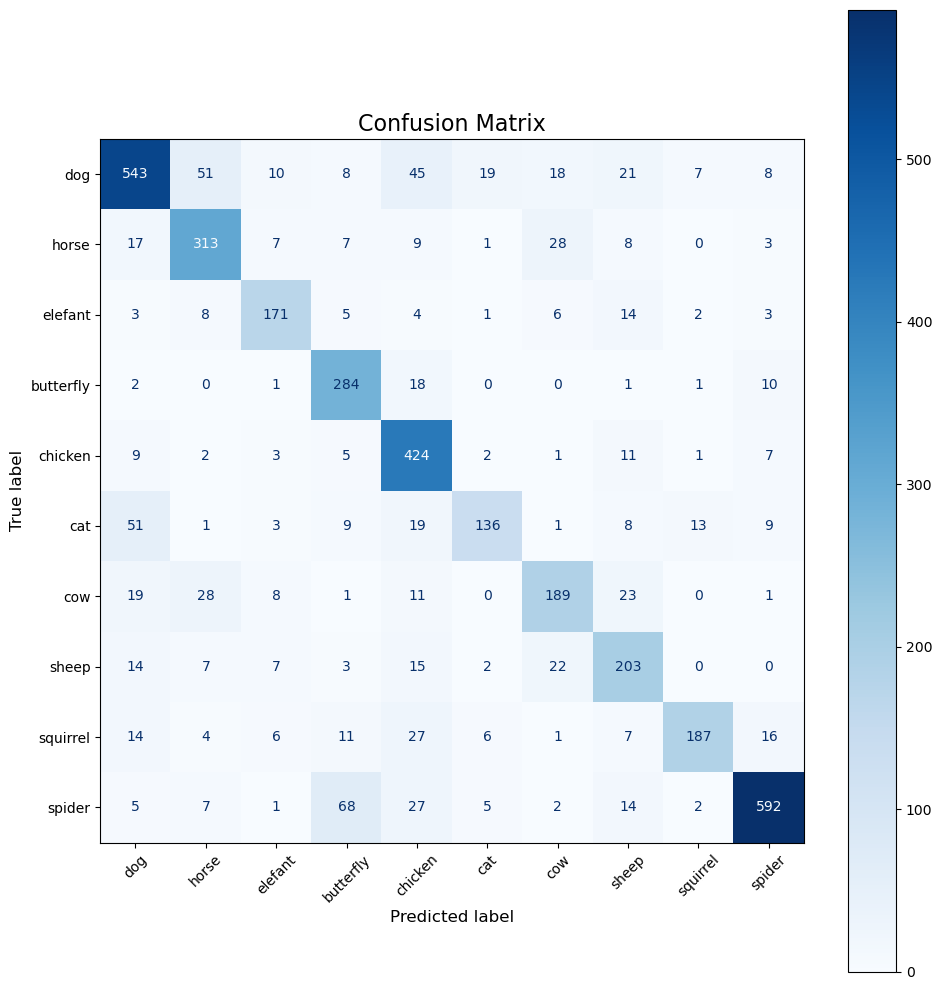

In [21]:
best_model = load_model('CNN_best_model.h5')

# Normalize test data and predict
x_test_normalized = x_test / 255.0
y_pred = best_model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=animals)
# Adjust figure size and font size for better label visibility
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)  # Rotate x-axis labels for better visibility

plt.title("Confusion Matrix", fontsize=16)  # Increase title font size
plt.xlabel("Predicted label", fontsize=12)  # Increase x-axis label font size
plt.ylabel("True label", fontsize=12)      # Increase y-axis label font size
plt.tight_layout()  # Ensure layout fits within the figure bounds
plt.show()